In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
MODEL_NAME = "simple_transformer"
V_NUM = 1
SYMBOL = "USDJPY"
MINUTES = 1
EVENT = '115009542m-dollar'
START_DATE = "20210101"
END_DATE = "20241231"
EVENT_NAME = "cusum_filter"
SEQUENCE_LENGTH = 120
TIME_COLS = [
    # 'timestamp',
    "hour",
    "dow",
    "dom",
    "month",
    # "open",
    # "high",
    # "low",
    # "close",
]
FEATURES_COLS = [
    "hour_cos",
    "dow_cos",
    "dom_cos",
    "month_cos",
    # Basic Data
    "close_log_return",
    "ret_mean_5",
    "ret_mean_10",
    "log_volume",
    "ema5_slope",
    "ema20_slope",
    "atr20",
    "vol_adj_return",
    "close_to_atr",
    "macd_diff",
    "bb_width",
    "bb_position",
    "donchian_width",
]

TARGET_COL = "bin_class"

In [3]:
from pathlib import Path

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SYMBOL}-{EVENT}-{START_DATE}-{END_DATE}"
LABEL_NAME = f"{RESAMPLED_NAME}-{EVENT_NAME}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
LABEL_DIR = BASE_DIR / "labels"
PROCESSED_DIR = BASE_DIR / "processed"
NORMALIZED_DIR = BASE_DIR / "normalized"
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
PREDICTION_DIR = BASE_DIR / "predictions"

# Final paths
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}-processed.pkl"
NORMALIZED_FILE_PATH = NORMALIZED_DIR / f"{RESAMPLED_NAME}-normalized.pkl"
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"
PREDICTION_FILE_PATH = PREDICTION_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [4]:
MODEL_PATH = f'../lightning_logs/{MODEL_NAME}-{EVENT}-{EVENT_NAME}/version_{V_NUM}/checkpoints/best_checkpoint.ckpt'

In [5]:
SIDE_NAME = 'transformer_sides'

META_LABEL_DIR = BASE_DIR / "meta_labels"
META_LABEL_DIR.mkdir(parents=True, exist_ok=True)
META_LABEL_FILE_PATH = META_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{SIDE_NAME}.pkl"

In [6]:
%%time
df = pd.read_pickle(NORMALIZED_FILE_PATH)
labels_df = pd.read_pickle(DIRECTION_LABEL_FILE_PATH)

CPU times: user 711 μs, sys: 34.1 ms, total: 34.8 ms
Wall time: 49.6 ms


In [7]:
missing = labels_df.index.difference(df.index)
missing

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)

### Load Model

In [8]:
from models.classification.t2v_transformer_model import T2VTransformerModule
from models.classification.simple_transformer_model import SimpleTransformerModule

In [9]:
model = SimpleTransformerModule.load_from_checkpoint(MODEL_PATH)


## Get Side from Trained Model

In [10]:
# features = df[TIME_COLS + FEATURES_COLS]
features = df[FEATURES_COLS]

In [11]:
features.shape

(832151, 17)

In [12]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm


def extract_sequences(data: pd.DataFrame, t_events, lookback: int):
    """Extract valid sequences and events for batch processing."""
    sequences, valid_events = [], []
    data_values, data_index = data.values.astype(np.float32), data.index
    
    for t in t_events:
        try:
            if t in data_index:
                end_loc = data_index.get_loc(t)
                start_loc = end_loc - lookback
                if start_loc >= 0:
                    seq = data_values[start_loc:end_loc]
                    if len(seq) == lookback:
                        sequences.append(seq)
                        valid_events.append(t)
        except:
            continue
    
    return (np.stack(sequences), valid_events) if sequences else (None, [])

def get_side_from_model_batch(model, data: pd.DataFrame, labels: pd.DataFrame, 
                             lookback: int = 24, device: str = 'cpu', batch_size: int = 64):
    """Batch process model predictions for time series events."""
    model.eval().to(device)
    
    sequences, valid_events = extract_sequences(data, labels.index, lookback)
    if sequences is None:
        return pd.DataFrame()
    
    predictions, probabilities = [], []
    n_batches = (len(sequences) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(sequences), batch_size), total=n_batches, desc="Processing batches"):
        batch = sequences[i:i + batch_size]
        x_tensor = torch.tensor(batch, device=device)
        with torch.no_grad():
            logits = model(x_tensor)
            probs = torch.softmax(logits, dim=1)
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    result_df = pd.DataFrame(probabilities, index=valid_events)
    result_df.columns = [f'prob_{i}' for i in range(len(result_df.columns))]
    result_df['prediction'] = predictions
    result_df['side'] = result_df['prediction'] - 1
    
    return result_df

In [13]:
%%time
predictions = get_side_from_model_batch(model=model, data=features,labels=labels_df, lookback=SEQUENCE_LENGTH, device='mps', batch_size=1024)
print(predictions.side.value_counts())
print(predictions.isna().sum())

Processing batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:05<00:00, 26.76it/s]


side
-1    97593
 0    26125
 1    21069
Name: count, dtype: int64
prob_0        0
prob_1        0
prob_2        0
prediction    0
side          0
dtype: int64
CPU times: user 942 ms, sys: 314 ms, total: 1.26 s
Wall time: 5.98 s


In [14]:
labels_df = labels_df.join(predictions)

In [15]:
labels_df.shape

(144787, 11)

In [16]:
labels_df = labels_df.dropna()

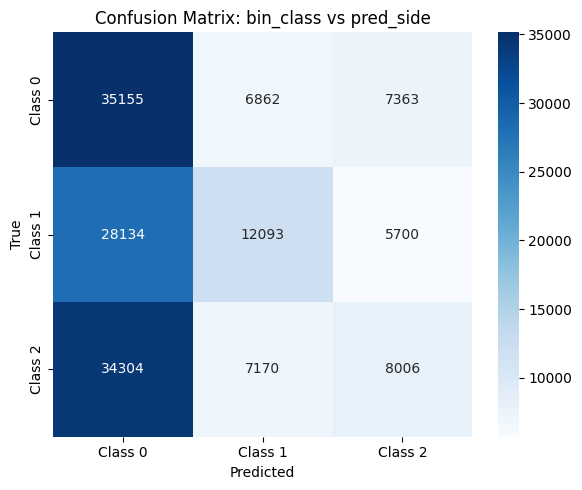

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 將類別轉為整數型別
y_true = labels_df["bin_class"].astype(int)
y_pred = labels_df["prediction"].astype(int)

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
labels = ["Class 0", "Class 1", "Class 2"]

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: bin_class vs pred_side")
plt.tight_layout()
plt.show()


In [18]:
labels_df.to_pickle(PREDICTION_FILE_PATH)

In [19]:
labels_df.columns

Index(['t1', 'trgt', 'duration', 'ret', 'bin', 'bin_class', 'prob_0', 'prob_1',
       'prob_2', 'prediction', 'side'],
      dtype='object')